#### This helped with the notebook in conda
https://medium.com/@nrk25693/how-to-add-your-conda-environment-to-your-jupyter-notebook-in-just-4-steps-abeab8b8d084

# M5 Forecasting Competition GluonTS Template

This notebook can be used as a starting point for participating in the [M5 forecasting competition](https://www.kaggle.com/c/m5-forecasting-accuracy/overview) using GluonTS-based tooling.



### Standard imports

First we import standard data manipulation libraries.

In [1]:
# import sys
# sys.path.append('/home/aleksei/miniconda3/envs/fcrn_bidding/lib/python3.7/site-packages')
# sys.path.append('/home/aleksei/miniconda3/envs/fcrn_bidding/bin/python')

In [2]:
%matplotlib inline
import mxnet as mx
from mxnet import gluon
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import os
from tqdm.autonotebook import tqdm
from pathlib import Path

/home/aleksei/miniconda3/envs/fcrn_bidding/lib/python3.7/site-packages/ipykernel_launcher.py:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  if __name__ == '__main__':


In [3]:
mx.random.seed(0)
np.random.seed(0)

We also define globally accessible variables, such as the prediction length and the input path for the M5 data. Note that `single_prediction_length` corresponds to the length of the validation/evaluation periods, while `submission_prediction_length` corresponds to the length of both these periods combined.

By default the notebook is configured to run in submission mode (`submission` will be `True`), which means that we use all of the data for training and predict new values for a total length of `submission_prediction_length` for which we don't have ground truth values available (performance can be assessed by submitting prediction results to Kaggle). In contrast, setting `submission` to `False` will instead use the last `single_prediction_length`-many values of our training set as validation points (and hence these values will not be used for training), which enables us to validate our model's performance offline.

In [49]:
single_prediction_length = 24
submission_prediction_length = single_prediction_length
m5_input_path="./"
submission=True

if submission:
    prediction_length = submission_prediction_length
else:
    prediction_length = single_prediction_length

### Data and features

In [3]:
df = pd.read_csv('./data/raw/fcrn_hourly_prices.csv', index_col=0)
df.index = pd.to_datetime(df.index)
df.index = df.index.tz_localize(None) #tz_convert('Europe/Helsinki')
df = df['2019-01-01 22:00:00':]
df['power'] = df['2019-01-01 22:00:00':]+1
df.head()

,value,power
timestamp,,
2019-01-01 22:00:00,30.0,31.0
2019-01-01 23:00:00,18.0,19.0
2019-01-02 00:00:00,21.0,22.0
2019-01-02 01:00:00,21.0,22.0
2019-01-02 02:00:00,21.0,22.0


In [4]:
df.tail()

,value,power
timestamp,,
2020-09-15 17:00:00,16.00,17.00
2020-09-15 18:00:00,7.88,8.88
2020-09-15 19:00:00,7.00,8.00
2020-09-15 20:00:00,8.00,9.00
2020-09-15 21:00:00,12.50,13.50


In [6]:
df.iloc[:-24]

,value,power
timestamp,,
2019-01-01 22:00:00,30.0,31.0
2019-01-01 23:00:00,18.0,19.0
2019-01-02 00:00:00,21.0,22.0
2019-01-02 01:00:00,21.0,22.0
2019-01-02 02:00:00,21.0,22.0
...,...,...
2020-09-14 17:00:00,11.6,12.6
2020-09-14 18:00:00,0.0,1.0
2020-09-14 19:00:00,12.4,13.4


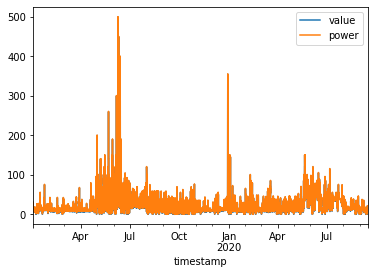

In [125]:
df.plot()

In [378]:
def create_dataset(num_series, num_steps, period=24, mu=1, sigma=0.3):
    # create target: noise + pattern
    # noise
    noise = np.random.normal(mu, sigma, size=(num_series, num_steps))

    # pattern - sinusoid with different phase
    sin_minumPi_Pi = np.sin(np.tile(np.linspace(-np.pi, np.pi, period), int(num_steps / period)))
    sin_Zero_2Pi = np.sin(np.tile(np.linspace(0, 2 * np.pi, 24), int(num_steps / period)))

    pattern = np.concatenate((np.tile(sin_minumPi_Pi.reshape(1, -1),
                                      (int(np.ceil(num_series / 2)),1)),
                              np.tile(sin_Zero_2Pi.reshape(1, -1),
                                      (int(np.floor(num_series / 2)), 1))
                             ),
                             axis=0
                            )

    target = noise + pattern

    # create time features: use target one period earlier, append with zeros
    feat_dynamic_real = np.concatenate((np.zeros((num_series, period)),
                                        target[:, :-period]
                                       ),
                                       axis=1
                                      )

    # create categorical static feats: use the sinusoid type as a categorical feature
    feat_static_cat = np.concatenate((np.zeros(int(np.ceil(num_series / 2))),
                                      np.ones(int(np.floor(num_series / 2)))
                                     ),
                                     axis=0
                                    )

    return target, feat_dynamic_real, feat_static_cat


# define the parameters of the dataset
custom_ds_metadata = {'num_series': 100,
                      'num_steps': 24 * 7,
                      'prediction_length': 24,
                      'freq': '1H',
                      'start': [pd.Timestamp("01-01-2019", freq='1H')
                                for _ in range(100)]
                     }


data_out = create_dataset(custom_ds_metadata['num_series'],
                          custom_ds_metadata['num_steps'],
                          custom_ds_metadata['prediction_length']
                         )

target, feat_dynamic_real, feat_static_cat = data_out


train_ds = ListDataset([{FieldName.TARGET: target,
                         FieldName.START: start,
                         FieldName.FEAT_DYNAMIC_REAL: [fdr],
                         FieldName.FEAT_STATIC_CAT: [fsc]}
                        for (target, start, fdr, fsc) in zip(target[:, :-custom_ds_metadata['prediction_length']],
                                                             custom_ds_metadata['start'],
                                                             feat_dynamic_real[:, :-custom_ds_metadata['prediction_length']],
                                                             feat_static_cat)],
                      freq=custom_ds_metadata['freq'])

test_ds = ListDataset([{FieldName.TARGET: target,
                        FieldName.START: start,
                        FieldName.FEAT_DYNAMIC_REAL: [fdr],
                        FieldName.FEAT_STATIC_CAT: [fsc]}
                       for (target, start, fdr, fsc) in zip(target,
                                                            custom_ds_metadata['start'],
                                                            feat_dynamic_real,
                                                            feat_static_cat)],
                     freq=custom_ds_metadata['freq'])

In [383]:
target

array([[1.4068921 , 0.61775108, 0.42768266, ..., 1.25167728, 1.35450653,
        0.62262276],
       [0.76258727, 0.73262368, 0.55240521, ..., 1.44929206, 1.74928036,
        0.79506427],
       [0.85828738, 0.94835086, 0.45550616, ..., 1.39204191, 1.54562762,
        0.81682998],
       ...,
       [0.81449071, 1.34211853, 1.83580876, ..., 0.60172589, 0.83085278,
        1.1793617 ],
       [1.17655443, 1.41162188, 1.99991033, ..., 0.28480807, 0.71933551,
        0.96588465],
       [1.68571197, 0.91613364, 1.23138651, ..., 0.2831692 , 0.72877728,
        1.41931993]])

In [381]:
feat_dynamic_real

array([[0.        , 0.        , 0.        , ..., 1.37703321, 1.23772032,
        1.11954711],
       [0.        , 0.        , 0.        , ..., 1.18448464, 1.39741681,
        1.37247871],
       [0.        , 0.        , 0.        , ..., 1.14928045, 1.39785883,
        0.74275114],
       ...,
       [0.        , 0.        , 0.        , ..., 0.52201733, 0.95999009,
        0.88889159],
       [0.        , 0.        , 0.        , ..., 0.52501192, 0.77180875,
        1.00694897],
       [0.        , 0.        , 0.        , ..., 1.08008821, 0.64512568,
        0.18292265]])

In [382]:
feat_static_cat

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [334]:
num_series = 2 
period = 24
# create time features: use target one period earlier, append with zeros
feat_dynamic_real = np.concatenate((np.zeros((num_series, period)),
                                    target[:, :-period]
                                   ),
                                   axis=1
                                  )

# create categorical static feats: use the sinusoid type as a categorical feature
feat_static_cat = np.concatenate((np.zeros(int(np.ceil(num_series / 2))),
                                  np.ones(int(np.floor(num_series / 2)))
                                 ),
                                 axis=0
                                )

In [338]:
feat_static_cat

array([0., 1.])

In [336]:
feat_dynamic_real.shape

(2, 14952)

In [171]:
from gluonts.dataset.artificial import ComplexSeasonalTimeSeries
from gluonts.dataset.common import ListDataset

artificial_dataset = ComplexSeasonalTimeSeries(
    num_series=10,
    prediction_length=21,
    freq_str="H",
    length_low=30,
    length_high=200,
    min_val=-10000,
    max_val=10000,
    is_integer=False,
    proportion_missing_values=0,
    is_noise=True,
    is_scale=True,
    percentage_unique_timestamps=1,
    is_out_of_bounds_date=True,
)

train_ds = ListDataset(artificial_dataset.train,
                        freq=artificial_dataset.metadata.freq)
test_ds = ListDataset(artificial_dataset.test,
                       freq=artificial_dataset.metadata.freq)

In [172]:
artificial_dataset.train

[{'start': Timestamp('1690-02-07 18:00:00', freq='H'),
  'target': array([ 239.62966754,  328.05060092,  457.8858077 ,  572.73386971,
          689.69442493,  841.19099148,  951.45769554, 1084.50115192,
         1155.01712115, 1175.28192849, 1236.31754913, 1251.17807656,
         1199.37914826, 1093.38851752, 1010.7423927 ,  892.67630656,
          771.38996446,  613.53017466,  538.99493852,  497.20213151,
          489.7367022 ,  580.77746298,  796.6504859 , 1079.55861142,
         1243.65255353, 1758.33810934, 2016.17494755, 2408.39483376,
         2887.57502929, 3188.64842561, 3668.1176831 , 3711.52462283,
         3929.61581772, 3898.9619238 , 3657.71016149, 3333.64992326,
         3093.64462467, 2789.17419171, 2320.15791854, 1984.17433115,
         1658.66901509, 1138.40597909, 1215.8985342 , 1018.33623182,
          928.94415343,  894.21014306]),
  'item_id': 0},
 {'start': Timestamp('2002-05-04 15:00:00', freq='H'),
  'target': array([  -32.74601305,  -126.23142705,   -80.080376

In [175]:
# get the first time series in the training set
train_entry = next(iter(train_ds))
train_entry#.values()

{'start': Timestamp('1690-02-07 18:00:00', freq='H'),
 'target': array([ 239.62967,  328.0506 ,  457.8858 ,  572.7339 ,  689.6944 ,
         841.191  ,  951.4577 , 1084.5011 , 1155.0171 , 1175.282  ,
        1236.3175 , 1251.1781 , 1199.3792 , 1093.3885 , 1010.7424 ,
         892.67633,  771.38995,  613.53015,  538.99493,  497.20212,
         489.7367 ,  580.77747,  796.6505 , 1079.5586 , 1243.6526 ,
        1758.3381 , 2016.1749 , 2408.3948 , 2887.575  , 3188.6484 ,
        3668.1177 , 3711.5247 , 3929.6157 , 3898.962  , 3657.7102 ,
        3333.65   , 3093.6445 , 2789.174  , 2320.158  , 1984.1743 ,
        1658.6691 , 1138.406  , 1215.8986 , 1018.33624,  928.94415,
         894.21014], dtype=float32),
 'item_id': 0,
 'source': SourceContext(source='list_data', row=0)}

In [256]:
for ts in target:
    print(ts)
    print(np.zeros(1, prediction_length))

[30.  18.  21.  ...  7.   8.  12.5]


TypeError: data type not understood

Finally, we can build both the training and the testing set from target values and both static and dynamic features.

In [390]:
# create time features: use target one period earlier, append with zeros
num_series = df.shape[1]
target = df.values.T #reshape(df.shape[1], df.shape[0])
feat_dynamic_real_train = np.array([list(np.append(np.ones(prediction_length) * 0, ts[:-prediction_length])) for ts in target])
feat_dynamic_real_test = np.array([list(np.append(np.ones(prediction_length) * 0, ts[:])) for ts in target])


In [391]:
feat_dynamic_real_test

array([[ 0. ,  0. ,  0. , ...,  7. ,  8. , 12.5],
       [ 0. ,  0. ,  0. , ...,  8. ,  9. , 13.5]])

In [393]:
feat_dynamic_real_train

array([[ 0. ,  0. ,  0. , ..., 12.4, 13.6, 15. ],
       [ 0. ,  0. ,  0. , ..., 13.4, 14.6, 16. ]])

In [345]:
target

array([[30. , 18. , 21. , ...,  7. ,  8. , 12.5],
       [31. , 19. , 22. , ...,  8. ,  9. , 13.5]])

In [192]:
target[:, :-prediction_length]

array([[30. , 18. , 21. , ..., 12.4, 13.6, 15. ],
       [31. , 19. , 22. , ..., 13.4, 14.6, 16. ]])

In [195]:
feat_dynamic_real_train

array([[ 0. ,  0. ,  0. , ..., 12.4, 13.6, 15. ],
       [ 0. ,  0. ,  0. , ..., 13.4, 14.6, 16. ]])

In [198]:
test_target_values

[array([30., 18., 21., ...,  0.,  0.,  0.]),
 array([31., 19., 22., ...,  0.,  0.,  0.])]

In [240]:
train_df.shape[1]

(14952, 2)

In [302]:
'dsd /sddsd'.split('/')[-1]

'sddsd'

In [307]:
df.index

DatetimeIndex(['2019-01-01 22:00:00', '2019-01-01 23:00:00',
               '2019-01-02 00:00:00', '2019-01-02 01:00:00',
               '2019-01-02 02:00:00', '2019-01-02 03:00:00',
               '2019-01-02 04:00:00', '2019-01-02 05:00:00',
               '2019-01-02 06:00:00', '2019-01-02 07:00:00',
               ...
               '2020-09-15 12:00:00', '2020-09-15 13:00:00',
               '2020-09-15 14:00:00', '2020-09-15 15:00:00',
               '2020-09-15 16:00:00', '2020-09-15 17:00:00',
               '2020-09-15 18:00:00', '2020-09-15 19:00:00',
               '2020-09-15 20:00:00', '2020-09-15 21:00:00'],
              dtype='datetime64[ns]', name='timestamp', length=14952, freq=None)

In [411]:
from gluonts.dataset.common import load_datasets, ListDataset
from gluonts.dataset.field_names import FieldName

train_df = df #sales_train_validation.drop(["id","item_id","dept_id","cat_id","store_id","state_id"], axis=1)
train_target_values = train_df.T.values #.reshape(df.shape[1], train_df.shape[0])
submission = True

if submission == True:
    test_target_values = np.array([list(np.append(ts, np.ones(prediction_length) * 0)) for ts in train_target_values])
else:
    test_target_values = train_target_values.copy()
    train_target_values = [ts[:-prediction_length] for ts in train_target_values]

m5_dates = np.array([pd.Timestamp(df.index[0], freq='1H') for _ in range(train_df.shape[1])])
feat_dynamic_static = np.array([0, 1])

train_ds = ListDataset([
    {
        FieldName.TARGET: target,
        FieldName.START: start,
        FieldName.FEAT_DYNAMIC_REAL: [fdr],
        FieldName.FEAT_STATIC_CAT: [fsc]
    }
    for (target, start, fdr, fsc) in zip(train_target_values,
                                    m5_dates,
                                    feat_dynamic_real_train,
                                    feat_dynamic_static)
], freq="H")

test_ds = ListDataset([
    {
        FieldName.TARGET: target,
        FieldName.START: start,
        FieldName.FEAT_DYNAMIC_REAL: [fdr],
        FieldName.FEAT_STATIC_CAT: [fsc]
    } 
    for (target, start, fdr, fsc) in zip(test_target_values,
                                    m5_dates,
                                    feat_dynamic_real_test,
                                    feat_dynamic_static)
], freq="H")

In [405]:
m5_dates

array([Timestamp('2019-01-01 22:00:00', freq='H'),
       Timestamp('2019-01-01 22:00:00', freq='H')], dtype=object)

In [406]:
train_target_values

array([[30. , 18. , 21. , ...,  7. ,  8. , 12.5],
       [31. , 19. , 22. , ...,  8. ,  9. , 13.5]])

In [407]:
test_target_values

array([[30., 18., 21., ...,  0.,  0.,  0.],
       [31., 19., 22., ...,  0.,  0.,  0.]])

In [401]:
feat_dynamic_real_test

array([[ 0. ,  0. ,  0. , ...,  7. ,  8. , 12.5],
       [ 0. ,  0. ,  0. , ...,  8. ,  9. , 13.5]])

In [408]:
[
    {
        FieldName.TARGET: target,
        FieldName.START: start,
        FieldName.FEAT_DYNAMIC_REAL: [fdr],
        FieldName.FEAT_STATIC_CAT: [fsc]
    } 
    for (target, start, fdr, fsc) in zip(test_target_values,
                                    m5_dates,
                                    feat_dynamic_real_test,
                                    feat_dynamic_static
                                   )]

[{'target': array([30., 18., 21., ...,  0.,  0.,  0.]),
  'start': Timestamp('2019-01-01 22:00:00', freq='H'),
  'feat_dynamic_real': [array([ 0. ,  0. ,  0. , ...,  7. ,  8. , 12.5])],
  'feat_static_cat': [0]},
 {'target': array([31., 19., 22., ...,  0.,  0.,  0.]),
  'start': Timestamp('2019-01-01 22:00:00', freq='H'),
  'feat_dynamic_real': [array([ 0. ,  0. ,  0. , ...,  8. ,  9. , 13.5])],
  'feat_static_cat': [1]}]

In [409]:
np.array(feat_dynamic_real_test[:,:])

array([[ 0. ,  0. ,  0. , ...,  7. ,  8. , 12.5],
       [ 0. ,  0. ,  0. , ...,  8. ,  9. , 13.5]])

Just to be sure, we quickly verify that dataset format is correct and that our dataset does indeed contain the correct target values as well as dynamic and static features.

In [412]:
next(iter(train_ds))

{'target': array([30. , 18. , 21. , ...,  7. ,  8. , 12.5], dtype=float32),
 'start': Timestamp('2019-01-01 22:00:00', freq='H'),
 'feat_dynamic_real': array([[ 0. ,  0. ,  0. , ..., 12.4, 13.6, 15. ]], dtype=float32),
 'feat_static_cat': array([0], dtype=int32),
 'source': SourceContext(source='list_data', row=0)}

### Define a transformation

### Define the estimator

Having obtained our training and testing data, we can now create a GluonTS estimator. In our example we will use the `DeepAREstimator`, an autoregressive RNN which was developed primarily for the purpose of time series forecasting. Note however that you can use a variety of different estimators. Also, since GluonTS is mainly target at probabilistic time series forecasting, lots of different output distributions can be specified. In the M5 case, we think that the `NegativeBinomialOutput` distribution best describes the output.

For a full list of available estimators and possible initialization arguments see https://gluon-ts.mxnet.io/api/gluonts/gluonts.model.html.

For a full list of available output distributions and possible initialization arguments see https://gluon-ts.mxnet.io/api/gluonts/gluonts.distribution.html.

In [379]:
from gluonts.model.deepar import DeepAREstimator
from gluonts.distribution.neg_binomial import NegativeBinomialOutput
from gluonts.trainer import Trainer
from gluonts import time_feature

estimator = DeepAREstimator(
    prediction_length=24,
    freq="H",
    context_length = 168,
    distr_output = NegativeBinomialOutput(),
    use_feat_dynamic_real=True,
    dropout_rate = 0.1,
    #use_feat_static_cat=True,
    #cardinality=stat_cat_cardinalities,
    cell_type = 'lstm', #'gru'
#     time_features=[time_feature.HourOfDay(),
#                    time_feature.DayOfWeek(),
#                    time_feature.WeekOfYear()
#                    time_feature.DayOfMonth(),
#                    time_feature.MonthOfYear()],
    #dropoutcell_type = "VariationalDropoutCell",
    trainer=Trainer(#ctx="cpu",
                    learning_rate=1e-3,
                    epochs=1,
                    num_batches_per_epoch=50,
                    batch_size=32
    )
)

predictor = estimator.train(train_ds)

  0%|          | 0/50 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


100%|██████████| 50/50 [00:13<00:00,  3.60it/s, epoch=1/1, avg_epoch_loss=1.26]


### Generating forecasts

Once the estimator is fully trained, we can generate predictions from it for the test values.

In [15]:
from gluonts.evaluation.backtest import make_evaluation_predictions

forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,
    predictor=predictor,
    num_samples=100
)

print("Obtaining time series conditioning values ...")
tss = list(tqdm(ts_it, total=len(test_ds)))
print("Obtaining time series predictions ...")
forecasts = list(tqdm(forecast_it, total=len(test_ds)))

Obtaining time series conditioning values ...



Obtaining time series predictions ...


In [16]:
# first entry of the forecast list
forecast_entry = forecasts[0]
ts_entry = tss[0]

In [32]:
from datetime import datetime, timedelta 
ts_entry.index[-1] + timedelta(days=1)

Timestamp('2020-09-17 21:00:00', freq='H')

In [47]:
start = datetime.now().replace(hour=1, minute=0, second=0, microsecond=0) + timedelta(days=1)
end = start + timedelta(hours=23)
dff = pd.DataFrame(index=pd.date_range(start=start, end=end, freq='H'))
dff['new'] = np.random.randint(0,30,size=24)
dff

,new
2020-09-18 01:00:00,17
2020-09-18 02:00:00,8
2020-09-18 03:00:00,17
2020-09-18 04:00:00,10
2020-09-18 05:00:00,26
2020-09-18 06:00:00,11
2020-09-18 07:00:00,10
2020-09-18 08:00:00,2
2020-09-18 09:00:00,0
2020-09-18 10:00:00,22


In [17]:
print(f"Mean of the future window:\n {forecast_entry.mean}")
print(f"0.5-quantile (median) of the future window:\n {forecast_entry.quantile(0.7)}")

Mean of the future window:
 [16.01 15.16 11.98 12.11 15.64 17.44 14.33 13.4  15.55 17.03 17.24 15.37
 16.51 17.71 16.92 19.47 18.84 15.47 17.19 15.35 18.32 15.91 16.03 14.39]
0.5-quantile (median) of the future window:
 [17. 19. 15. 16. 17. 22. 16. 17. 18. 22. 23. 18. 20. 23. 20. 24. 21. 21.
 18. 18. 23. 19. 17. 19.]


### Local performance validation (if `submission` is `False`)

Since we don't want to constantly submit our results to Kaggle, it is important to being able to evaluate performace on our own validation set offline. To do so, we create a custom evaluator which, in addition to GluonTS's standard performance metrics, also returns `MRMSSE` (corresponding to the mean RMSSE). Note that the official score for the M5 competition, the `WRMSSE`, is not yet computed. A future version of this notebook will replace the `MRMSSE` by the `WRMSSE`.

In [18]:
from gluonts.evaluation import Evaluator
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(test_ds))

Running evaluation: 100%|██████████| 1/1 [00:00<00:00, 22.50it/s]
/home/aleksei/miniconda3/envs/fcrn_bidding/lib/python3.7/site-packages/gluonts/evaluation/_base.py:402: RuntimeWarning: divide by zero encountered in true_divide
  totals[quantile.loss_name], totals["abs_target_sum"]


In [21]:
iter(tss)

In [19]:
print(json.dumps(agg_metrics, indent=4))

{
    "MSE": 258.5428466796875,
    "abs_error": 293.0,
    "abs_target_sum": 0.0,
    "abs_target_mean": 0.0,
    "seasonal_error": 11.297277975951232,
    "MASE": 1.0806437939582867,
    "MAPE": 0.0,
    "sMAPE": 2.0,
    "OWA": NaN,
    "MSIS": 5.790480397660445,
    "QuantileLoss[0.1]": 99.00000000000001,
    "Coverage[0.1]": 1.0,
    "QuantileLoss[0.5]": 293.0,
    "Coverage[0.5]": 1.0,
    "QuantileLoss[0.9]": 165.99999999999997,
    "Coverage[0.9]": 1.0,
    "RMSE": 16.07926760395782,
    "NRMSE": 0.0,
    "ND": 0.0,
    "wQuantileLoss[0.1]": Infinity,
    "wQuantileLoss[0.5]": Infinity,
    "wQuantileLoss[0.9]": Infinity,
    "mean_wQuantileLoss": Infinity,
    "MAE_Coverage": 0.5
}


### Plotting sample predictions

Finally, we can also visualize our predictions for some of the time series.

Plotting time series predictions ...


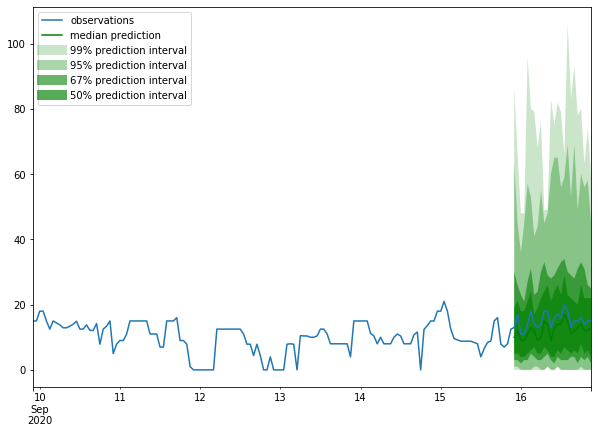

<Figure size 432x288 with 0 Axes>

In [20]:
plot_log_path = "./plots/"
directory = os.path.dirname(plot_log_path)
if not os.path.exists(directory):
    os.makedirs(directory)
    
def plot_prob_forecasts(ts_entry, forecast_entry, path, sample_id, inline=True):
    plot_length = 168
    prediction_intervals = (50, 67, 95, 99)
    ts_entry['2020-09-15 22:00:00':] = forecast_entry.quantile(0.6).reshape(24,1)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    _, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts_entry[-plot_length:].plot(ax=ax)
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    ax.axvline(ts_entry.index[prediction_length], color='r')
    plt.legend(legend, loc="upper left")
    if inline:
        plt.show()
        plt.clf()
    else:
        plt.savefig('{}forecast_{}.pdf'.format(path, sample_id))
        plt.close()

print("Plotting time series predictions ...")
for i in tqdm(range(1)):
    ts_entry = tss[i]
    forecast_entry = forecasts[i]
    plot_prob_forecasts(ts_entry, forecast_entry, plot_log_path, i)

### Saving/Loading the model

In [140]:
# save the trained model in tmp/
from pathlib import Path
predictor.serialize(Path("./data/training/"))

In [141]:
# loads it back
from gluonts.model.predictor import Predictor
predictor_deserialized = Predictor.deserialize(Path("./data/training/"))